### Import the needed package

In [28]:
import sys
sys.path.insert(0, './../')

import os
import numpy as np
import pandas as pd
import utilities as utils
import tensorflow as tf
import matplotlib.pyplot as plt

from random import randint
from skimage.measure import label, regionprops
from dotenv import load_dotenv
load_dotenv()

True

### Global variables

In [2]:
path_full = os.environ.get("ORI_PATH")
path_dataset = os.path.join(path_full, "datasets", "splitted", "augmented", "test")
path_cdr_data = os.path.join(path_full, "data", "cdr_dataset.csv")

### Get the test mask images information

In [3]:
cdr_data = pd.read_csv(path_cdr_data)
cdr_data.head(5)

,id,label,eye_side,a_cdr,v_cdr,h_cdr
0,fff_0_111784_l_y_mask,0,l,0.340206,0.633803,0.560606
1,fff_0_111784_r_y_mask,0,r,0.300445,0.541667,0.538462
2,fff_0_113060_l_1_mask,0,l,0.473950,0.686275,0.670000
3,fff_0_113060_l_2_mask,0,l,0.516781,0.777778,0.680000
4,fff_0_113060_l_3_mask,0,l,0.491304,0.721154,0.697917


In [4]:
f_images = [img for img in os.listdir(path_dataset) if img.endswith(".jpg")]

test_img = pd.DataFrame(f_images, columns=["image"])
test_img["id"] = test_img["image"].apply(lambda x: x.split(".")[0])
test_img = test_img[['id', 'image']]
test_img["label"] = test_img["id"].apply(lambda x: x.split("_")[1])
test_img["eye_side"] = test_img["id"].apply(lambda x: x.split("_")[3])
test_img["image"] = test_img["image"].apply(lambda x: os.path.join(path_dataset, x))
test_img.rename(columns={"image": "path"}, inplace=True)

test_img.drop(columns=["path"]).head(5)

,id,label,eye_side
0,fff_0_115058_l_1_aug,0,l
1,fff_0_115058_r_3_aug,0,r
2,fff_0_121076_r_1_aug,0,r
3,fff_0_121362_l_1_aug,0,l
4,fff_0_121362_l_3_aug,0,l


In [5]:
rand_idx = randint(0, len(test_img))
img = tf.io.read_file(test_img.path[rand_idx])
img = tf.image.decode_jpeg(img, channels=3)
img = tf.image.resize(img, [128, 128], method='nearest')
img = tf.cast(img, tf.float32) / 255.
img = tf.expand_dims(img, axis=0)

In [6]:
def mean_px_acc(y_true, y_pred):
    """a custom metric to calculate the mean pixel accuracy

    Args:
        y_true (tf.Tensor): the true mask
        y_pred (tf.Tensor): the predicted mask

    Returns:
        tf.Tensor: the mean pixel accuracy
    """
    # get the index of the maximum value in the mask
    y_pred = tf.argmax(y_pred, axis=-1)
    y_true = tf.argmax(y_true, axis=-1)
    # get the component of the number of correct pixels and total pixels
    correct_pixels = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred), tf.float32), axis=[1, 2])
    total_pixels = tf.reduce_sum(tf.ones_like(y_true, dtype=tf.float32), axis=[1,2])
    # calculate the mean pixel accuracy
    return tf.reduce_mean(correct_pixels / total_pixels)

In [7]:
model = tf.keras.models.load_model(os.path.join(path_full,
                                                "data",
                                                "model",
                                                "unet_model_aug.h5"),
                                    custom_objects={"mean_px_acc": mean_px_acc})

In [8]:
pred_mask = model.predict(img)

1/1 [==============================] - 15s 15s/step


In [9]:
pred_mask.shape

(1, 128, 128, 3)

In [10]:
ori_mask = cdr_data.loc[cdr_data.id == test_img.id[rand_idx].replace("aug", "mask")]
ori_mask.id.values[0]

'fff_0_115058_l_1_mask'

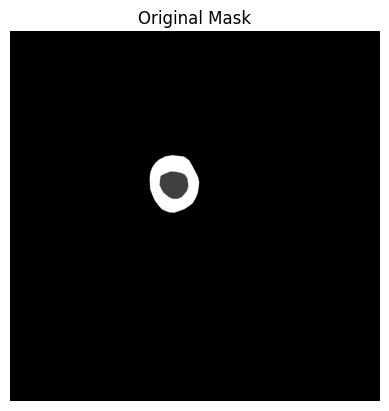

In [31]:
plt.imshow(plt.imread(os.path.join(path_dataset,
                                f"{ori_mask.id.values[0]}.png")),
            cmap="gray")
plt.title("Original Mask")
plt.axis("off")
plt.show()

In [15]:
threshold = .5
b_cup_mask = tf.where(pred_mask[..., 1] > threshold, 1, 0)
b_disc_mask = tf.where(pred_mask[..., 2] > threshold, 1, 0)

In [22]:
cup_bbox = regionprops(label(b_cup_mask.numpy())[0])[0].bbox
disc_bbox = regionprops(label(b_disc_mask.numpy())[0])[0].bbox

cup_width = cup_bbox[3] - cup_bbox[1]
cup_height = cup_bbox[2] - cup_bbox[0]
disc_width = disc_bbox[3] - disc_bbox[1]
disc_height = disc_bbox[2] - disc_bbox[0]

In [30]:
print(f"Area CDR: {np.sum(b_cup_mask) / np.sum(np.logical_or(b_cup_mask, b_disc_mask))}",
        f"Horizontal CDR: {cup_width / disc_width}",
        f"Vertical CDR: {cup_height / disc_height}",
        sep="\n")

Area CDR: 0.26900584795321636
Horizontal CDR: 0.55
Vertical CDR: 0.5


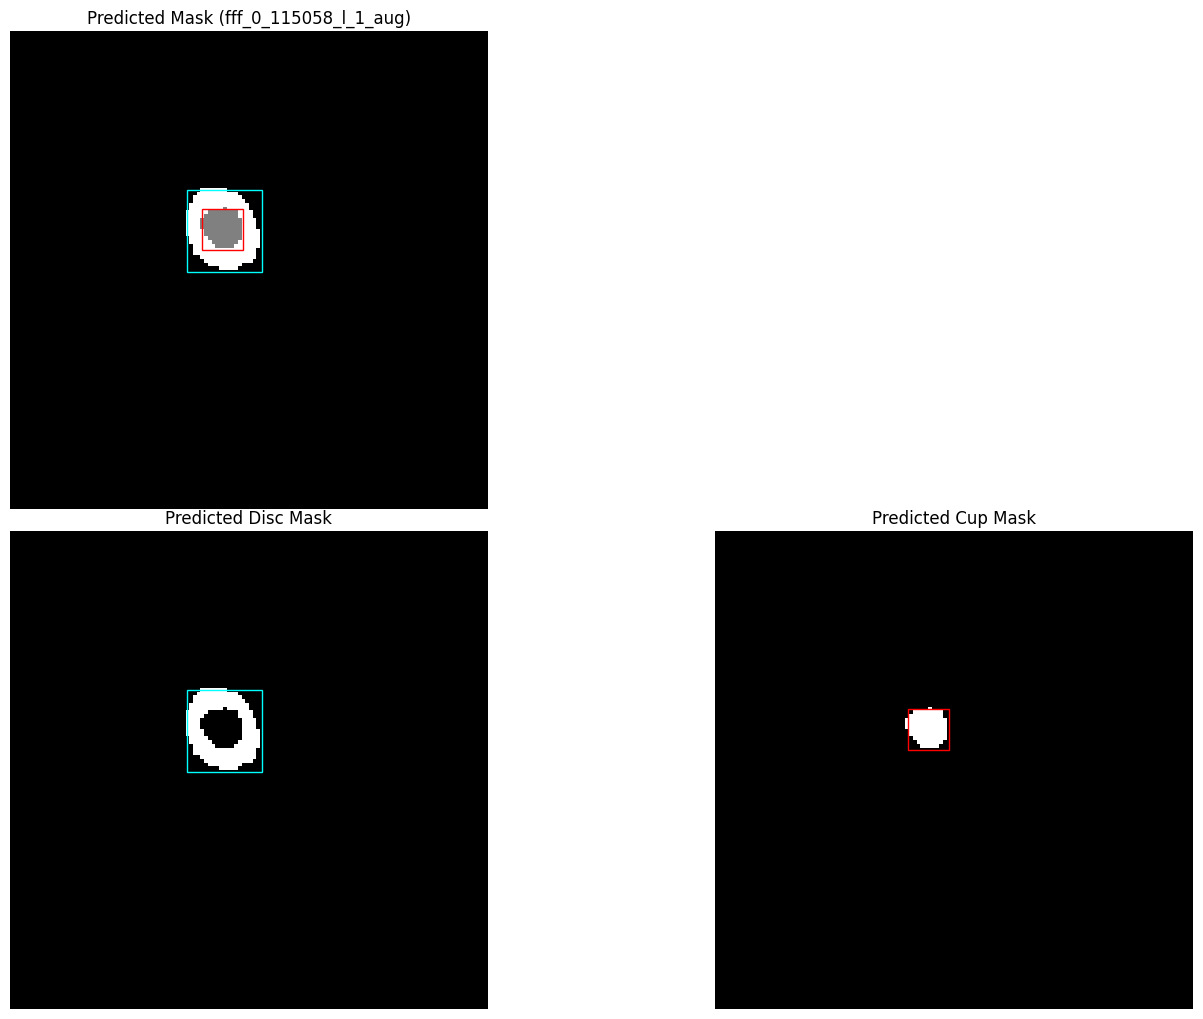

In [ ]:
plt.figure(figsize=(15, 10))

plt.subplot(2,2, 1)
plt.imshow(tf.argmax(pred_mask, axis=-1)[0], cmap='gray')
plt.gca().add_patch(plt.Rectangle((cup_bbox[1], cup_bbox[0]),
                                    cup_width,
                                    cup_height,
                                    edgecolor='red',
                                    facecolor='none'))
plt.gca().add_patch(plt.Rectangle((disc_bbox[1], disc_bbox[0]),
                                    disc_width,
                                    disc_height,
                                    edgecolor='cyan',
                                    facecolor='none'))
plt.title(f"Predicted Mask ({test_img.id[rand_idx]})")
plt.axis('off')

plt.subplot(2,2, 3)
plt.imshow(b_disc_mask[0], cmap='gray')
plt.gca().add_patch(plt.Rectangle((disc_bbox[1], disc_bbox[0]),
                                    disc_width,
                                    disc_height,
                                    edgecolor='cyan',
                                    facecolor='none'))
plt.title("Predicted Disc Mask")
plt.axis('off')

plt.subplot(2,2, 4)
plt.imshow(b_cup_mask[0], cmap='gray')
plt.gca().add_patch(plt.Rectangle((cup_bbox[1], cup_bbox[0]),
                                    cup_width,
                                    cup_height,
                                    edgecolor='red',
                                    facecolor='none'))
plt.title("Predicted Cup Mask")
plt.axis('off')

plt.tight_layout(pad=0)
plt.show()

In [ ]:
test_img, test_mask = utils.load_img_mask(path_dataset)
testset = utils.create_dataset(test_img, test_mask)

In [3]:
predicted_mask, model = utils.predict_model(testset, file_name="unet_model_aug", batches=8, get_one=False)


1/1 [==============================] - 0s 185ms/step


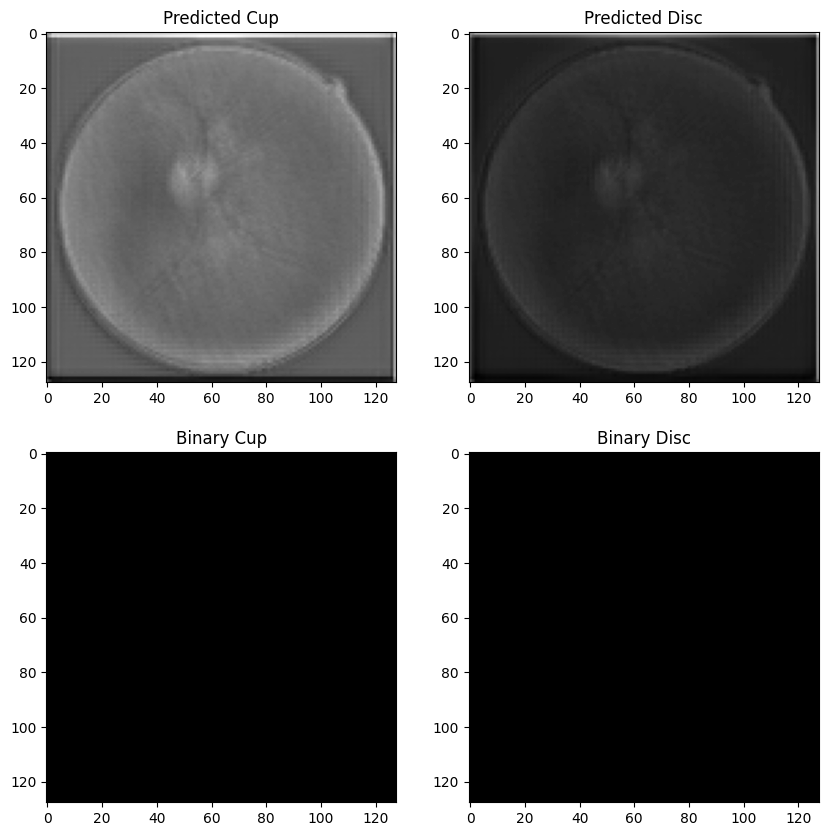

In [27]:
cup_mask, disc_mask, bcup_mask, bdisc_mask = utils.split_disc_cup_mask(predicted_mask[0], treshold=.2, img_idx=5)

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

Mask shape:  (128, 128, 3)


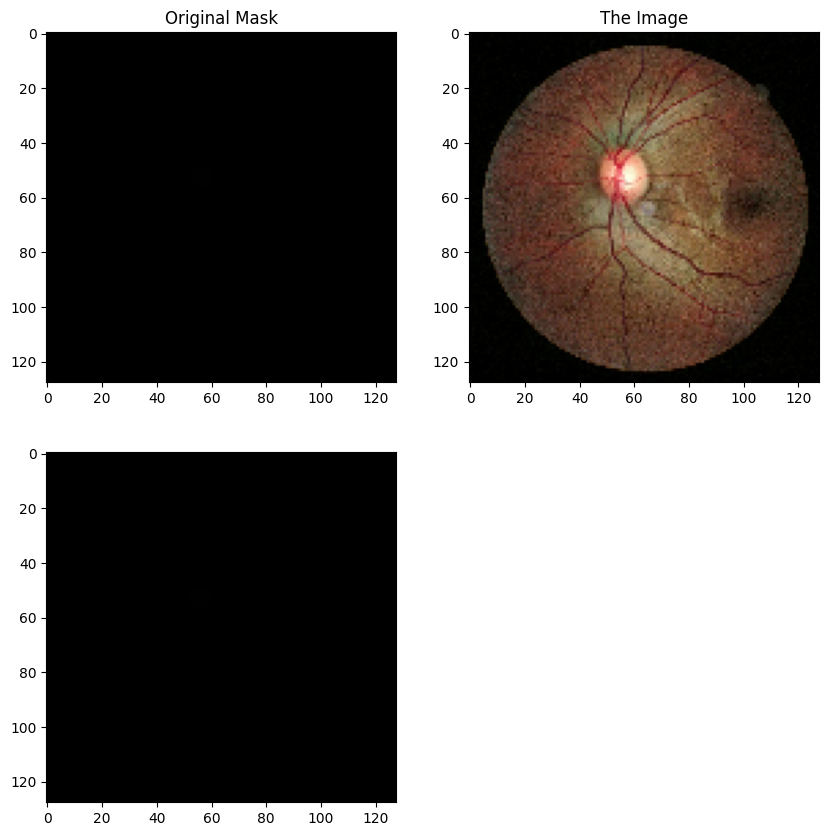

In [29]:
for image, mask in testset.take(1):
    update_mask = tf.where(mask == 2, 0, mask)
    # update_mask = tf.where(mask == 2, 1, mask)
    
    idx=0
    print("Mask shape: ", mask[idx].shape)
    plt.figure(figsize=(10, 10))
    plt.subplot(2,2, 1)
    plt.imshow(mask[idx], cmap="gray")
    plt.title("Original Mask")
    plt.subplot(2,2, 2)
    plt.imshow(image[idx])
    plt.title("The Image")
    plt.subplot(2,2, 3)
    plt.imshow(update_mask[idx], cmap="gray")

(16, 128, 128, 3)


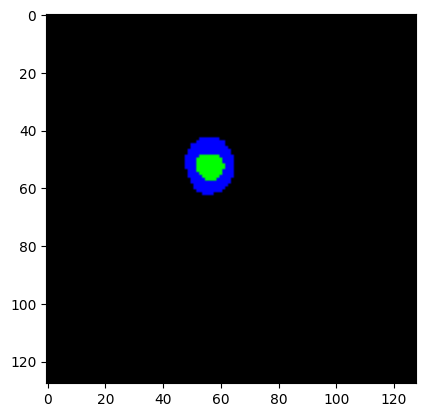

In [12]:
mask_indices = np.argmax(mask, axis=-1)
colormap = np.array([[0, 0, 0],       # background - black
                     [0, 255, 0],     # disc - green
                     [0, 0, 255]])    # cup - blue

# Step 3: Map the class indices to colors
mask_rgb = colormap[mask_indices]
print(mask_rgb.shape)
plt.imshow(mask_rgb[0])

In [13]:
print(f"binary cup mask: {bcup_mask.shape}",
      f"cup mask: {cup_mask.shape}",
      f"predicted_mask: {predicted_mask[0].shape}",
      f"mask: {mask[0].shape}",
      sep="\n")

binary cup mask: (16, 128, 128)
cup mask: (16, 128, 128)
predicted_mask: (16, 128, 128, 3)
mask: (128, 128, 3)


Metrics:
- IoU = tp / (tp +fp + fn)
- Dice Score
- Precision
- Recal